In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
%load_ext autoreload
%autoreload 2

In [ ]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def img_float_to_uint16(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 256 * 256 - 1).round().astype(np.uint16)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
# Loaded a set of images
root_dir = "dataset/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 60 # Only use 10 images for training

In [ ]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [ ]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [ ]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    ####################################
    img=rgb2gray(img)
    img=skimage.img_as_ubyte(img)
    glcm=greycomatrix(img,[2],[0,np.pi/4,np.pi/2],256,symmetric=True, normed=True)
    diss=greycoprops(glcm,'dissimilarity').flatten()
    contrast=greycoprops(glcm,'contrast').flatten()
    correl = greycoprops(glcm,'correlation').flatten()
    homogen =greycoprops(glcm,'homogeneity').flatten()
    energy = greycoprops(glcm,'energy').flatten()
    feat=np.hstack((feat,contrast,diss,correl,homogen,energy))
    ###############################
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

In [ ]:
# Compute features for each image patch
foreground_threshold = 0.05 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [ ]:
greycomatrix(img_float_to_uint8(rgb2gray(img_patches[0])),[8],[0],np.max(img_float_to_uint8(rgb2gray(img_patches[0])))+1).shape

In [ ]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

In [ ]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

In [ ]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
#hpyer-parameter to vary
pca=decomposition.PCA(n_components=7)
pca.fit(X)
pca.explained_variance_ratio_

In [ ]:
nb_image=100
nb_features=8
#X=features.reshape((nb_image*img1.shape[0]*img1.shape[1],nb_features))
X=(X-X.mean(axis=0))/X.std(axis=0)
gt_imgs=np.asarray(gt_imgs)
#Y=gt_imgs.reshape((100*imgs[0].shape[0]*imgs[0].shape[1]))
Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]

X_pca = decomposition.PCA(n_components=3).fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap=plt.cm.Paired,edgecolors='k');

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 2],c=Y, cmap=plt.cm.Paired,edgecolors='k');

In [ ]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X_pca, Y)

In [ ]:
# Predict on the training set
Z = logreg.predict(X_pca)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

In [ ]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [3]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


## Potential steps to do:
* preprocessing to see image better (adaptive hist equ, ...)
* segmentation (cnn tensorflow is pretty efficient)
* classifier

## New part starting from here
### All previous works are just testing
try some new features mas texture over **each** pixels and classify all together using a SVM with a RBF kernel.

All hyperparameters will be tested using crossvalidation over a training set, and extracting a validation set from it

In [10]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import itertools
import tqdm
import pandas as pd
from PIL import Image
import cv2
import skimage
import skimage.segmentation as segm
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from sklearn import linear_model
from sklearn import decomposition
from sklearn import svm
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
TEST=False

Load all 100 training images

In [4]:
# Loaded a set of images
root_dir = "dataset/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
for i in range(n): 
    gt_imgs[i][gt_imgs[i]<=0.8]=0
    gt_imgs[i][gt_imgs[i]>0.8]=1
print(files[0])

n = 60 # Only use 10 images for training
Seed=16678

np.random.seed(Seed)
idx = range(len(imgs))
idx = np.random.permutation(idx)
#imgs_train = 

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Load all test images

In [5]:
# Load the test images
test_dir = "dataset/test_set_images/"
image_test_dir = "test_"
n_test=50   # should NEVER be higher

imgs_test = [load_image(test_dir+image_test_dir+"{}/".format(i)+image_test_dir+"{}.png".format(i)) for i in range(1,n_test+1)]

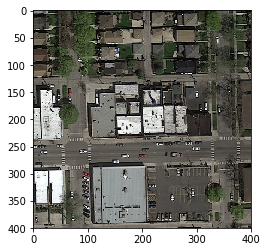

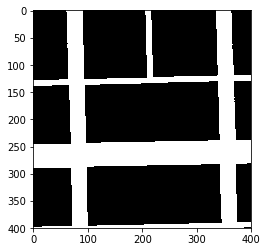

In [18]:
if(True):
    img1=load_image(image_dir+"satImage_098.png")
    gt1=load_image(gt_dir+"satImage_098.png")
    gt1[gt1<=0.8]=0
    gt1[gt1>0.8]=1
    img2=load_image_cv(image_dir+"satImage_002.png")
    plt.imshow(img1)
    #img1=cv2.bilateralFilter(img1,5,100,100)
    plt.figure()
    plt.imshow(gt1,cmap='gray')

extract texture features, with different orientation and distances

In [6]:
distances    = [1]
orientations = [0,np.pi/4,np.pi/2,3*np.pi/4]
num_glcm_features=2 #['dissimilarity','contrast']
def texture_feat(img):
    img=rgb2gray(img)
    img=skimage.img_as_ubyte(img)
    glcm=greycomatrix(img,distances,orientations,256,symmetric=True, normed=True)
    diss=greycoprops(glcm,'dissimilarity').flatten()
    contrast=greycoprops(glcm,'contrast').flatten()
    #correl = greycoprops(glcm,'correlation').flatten()
    #homogen =greycoprops(glcm,'homogeneity').flatten()
    #energy = greycoprops(glcm,'energy').flatten()
    del glcm
    feat=np.hstack((contrast,diss))#,correl,homogen,energy))
    return feat

#### Extract all features from all images:
* **SEGM**: divide the images in superpixels and regroup basic feature (mean and std of colors) for each superpixels
* **GLCM**: use the **WINDOW** neighboring pixels width to find texture applied for each pixels. (Maybe better to separate in patch, but proven the contrary when tested)

In [21]:
#Hyperparameter: n_segments, sigma
# higher segment computattionaly complex, less not enough segmentation
# higher sigma give too large superpixels, less, not enough information
WINDOW=7
STEP=1
SEGM=False
GLCM=True
features=[]
save_indiv=True
num_file=0
for image in imgs:#tqdm.tqdm(imgs):
    if(SEGM):
        segments=segm.slic(image,n_segments=200,sigma=3)
        x_idx = np.repeat(range(image.shape[0]), image.shape[1])
        x_idx = np.reshape(x_idx, image.shape[0:2])
        x_idx = np.transpose(x_idx)

        # pour calculer la position du barycentre dans la hauteur de l'image
        y_idx = np.repeat(range(image.shape[1]), image.shape[0])
        y_idx = np.reshape(y_idx, image.shape[0:2])
        # mean 3 colors, std 3 colors, position barycentre
        feature=np.zeros((image.shape[0],image.shape[1],8))
        nb_superpx=np.max(segments)+1
        for label in range(nb_superpx):
            idx = segments==label
            feature[idx]=np.asarray([np.mean(image[idx,0]),np.mean(image[idx,1]),np.mean(image[idx,2]),
                                      np.std(image[idx,0]),np.std(image[idx,1]),np.std(image[idx,2]),
                                     np.mean(x_idx[idx]),np.mean(y_idx[idx])])
    if(GLCM):
        padded_img=rgb2gray(image.copy())
        padded_img=skimage.util.pad(padded_img,WINDOW,'symmetric')
        patches_glcm=skimage.util.view_as_windows(padded_img,(2*WINDOW+1,2*WINDOW+1),STEP)
        texture=np.zeros(image.shape[:2]+(num_glcm_features*len(orientations)*len(distances),))
        for i,j in tqdm.tqdm(itertools.product(range(patches_glcm.shape[0]),range(patches_glcm.shape[1]))):
            patch=patches_glcm[i,j]
            texture[i,j]=texture_feat(patch.copy())
        try:
            feature=np.dstack((feature,texture))
        except:
            feature=texture
    if(not save_indiv):
        features.append(feature)
    else:
        X=feature.reshape((imgs[0].shape[0]*imgs[0].shape[1],-1))
        np.savetxt("feature_glcm_{}.txt".format(num_file),X,fmt='%.6e')
        num_file=num_file+1
        del X
    del feature
#features=np.asarray(features)

0it [00:00, ?it/s]c:\python35\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
160000it [15:15, 174.72it/s]
160000it [15:47, 168.93it/s]
160000it [14:30, 183.81it/s]
160000it [15:01, 177.58it/s]
160000it [14:30, 183.74it/s]
160000it [14:48, 180.05it/s]
160000it [14:42, 181.37it/s]
160000it [14:03, 189.69it/s]
160000it [14:21, 185.76it/s]
160000it [14:55, 178.60it/s]
160000it [14:46, 180.58it/s]
160000it [14:55, 178.66it/s]
160000it [14:30, 183.70it/s]
160000it [14:13, 187.51it/s]
160000it [14:07, 188.76it/s]
160000it [14:08, 188.61it/s]
160000it [14:11, 187.90it/s]
160000it [14:08, 188.53it/s]
160000it [14:08, 188.66it/s]
160000it [14:09, 188.30it/s]
160000it [14:10, 188.17it/s]
160000it [14:13, 187.37it/s]
160000it [14:11, 187.83it/s]
160000it [14:10, 188.09it/s]
160000it [14:12, 187.62it/s]
160000it [14:12, 187.75it/s]
160000it [14:12, 187.73it/s]
160000it [14:10, 188.02it/s]


In [ ]:
## Save the given features in a txt file
nb_image=features.shape[0]
nb_features=features.shape[3]
X=features.reshape((nb_image*imgs[0].shape[0]*imgs[0].shape[1],nb_features))
np.savetxt("feature_glcm.txt",X,fmt='%.10e')

In [ ]:
if(TEST):
    segments=segm.slic(img1,n_segments=200,sigma=3)
    plt.imshow(segm.mark_boundaries(img1,segments))
    plt.figure()
    plt.imshow(segm.mark_boundaries(gt1,segments))
    red=img1[:,:,0]
    green=img1[:,:,1]
    blue=img1[:,:,2]

    x_idx = np.repeat(range(img1.shape[0]), img1.shape[1])
    x_idx = np.reshape(x_idx, img1.shape[0:2])
    x_idx = np.transpose(x_idx)

    # pour calculer la position du barycentre dans la hauteur de l'image
    y_idx = np.repeat(range(img1.shape[1]), img1.shape[0])
    y_idx = np.reshape(y_idx, img1.shape[0:2])
    # mean 3 colors, std 3 colors, position barycentre
    features=np.zeros((img1.shape[0],img1.shape[1],8))
    nb_superpx=np.max(segments)+1
    for label in range(nb_superpx):
        idx = segments==label
        features[idx]=np.asarray([np.mean(img1[idx,0]),np.mean(img1[idx,1]),np.mean(img1[idx,2]),
                                  np.std(img1[idx,0]),np.std(img1[idx,1]),np.std(img1[idx,2]),
                                 np.mean(x_idx[idx]),np.mean(y_idx[idx])])
    #for i,j in itertools.product(range(img1.shape[0]),range(img1.shape[1])):
    #    features[i,j,0]

Load features from txt files

In [64]:
SEGM=True
GLCM=True
chosen_idx=range(100)
if(save_indiv):
    if(SEGM):
        print("Starting to load simple features file")
        X=pd.read_csv("feature_simple.txt", delimiter=' ', header=None, dtype=np.float).as_matrix()#np.loadtxt("feature_simple.txt")
        print("simple features loaded")
        X=X.reshape(100,imgs[0].shape[0]*imgs[1].shape[1],8)
        X=X[chosen_idx,:,:]
    if(GLCM):
        stub=np.zeros((len(chosen_idx),imgs[0].shape[0]*imgs[0].shape[1],num_glcm_features*len(orientations)*len(distances)))
        try:
            X=np.dstack((X,stub))
        except:
            X=stub
        print("Starting to load glcm features")
        for i in tqdm.tqdm(chosen_idx):
            feat_glcm=pd.read_csv("feature_glcm_{}.txt".format(i), delimiter=' ', header=None, dtype=np.float).as_matrix()#np.loadtxt("feature_glcm_{}.txt".format(i))
            X[i,:,-num_glcm_features*len(orientations)*len(distances):]=feat_glcm[:,:feat_glcm.shape[1]//3]
            if(SEGM and GLCM):
                np.savetxt("feature_all_{}.txt".format(i),X[i,:,:],fmt='%.10e')
        print("all glcm features loaded")
        del stub
        X=X.reshape(len(chosen_idx)*imgs[0].shape[0]*imgs[0].shape[1],-1)

Starting to load simple features file
simple features loaded
Starting to load glcm features


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


all glcm features loaded


In [7]:
chosen_idx=range(100)
X=np.zeros((len(chosen_idx),imgs[0].shape[0]*imgs[0].shape[1],num_glcm_features*len(orientations)*len(distances)+8))
for i in tqdm.tqdm(chosen_idx):
    features=pd.read_csv("feature_all_{}.txt".format(i), delimiter=' ', header=None, dtype=np.float).as_matrix()#np.loadtxt("feature_glcm_{}.txt".format(i))
    X[i,:,:]=features
X=X.reshape(len(chosen_idx)*imgs[0].shape[0]*imgs[0].shape[1],-1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


In [8]:
X.std(axis=0)/(X.max(axis=0)-X.min(axis=0))

array([ 0.15326704,  0.14774048,  0.15029057,  0.13667878,  0.13693997,
        0.13865261,  0.29253384,  0.29336023,  0.07336306,  0.08269323,
        0.06805472,  0.08781209,  0.10327064,  0.10567833,  0.0923926 ,
        0.11113477])

Check if all features are continuous and none are discrete.

Remove features with low variance, as they should not help with classification.

19it [00:04,  4.11it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
240it [00:59,  4.00it/s]


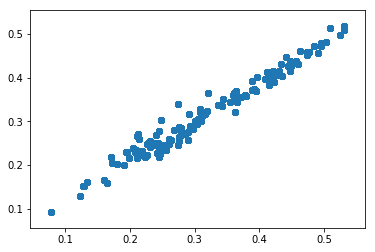

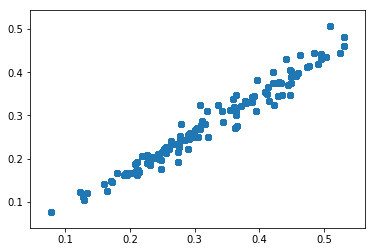

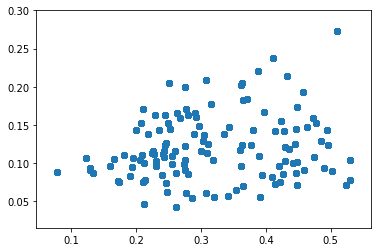

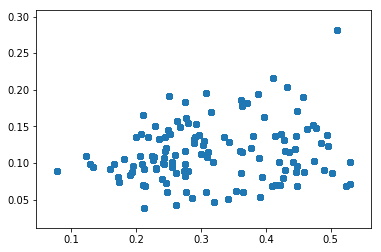

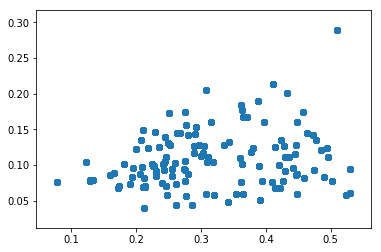

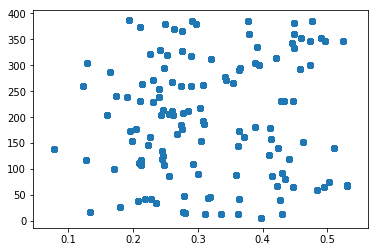

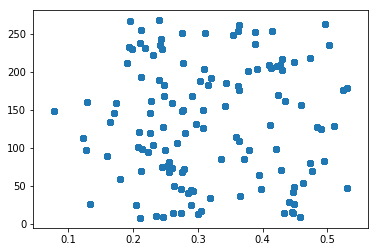

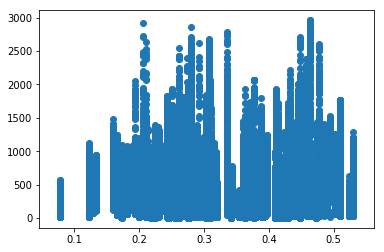

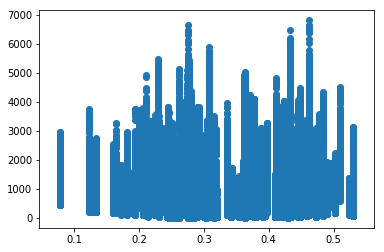

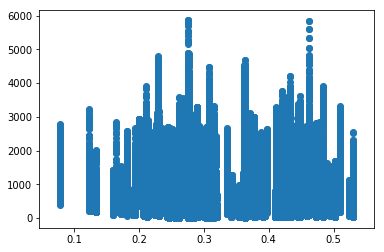

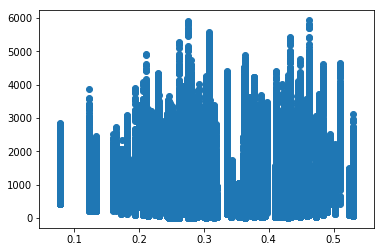

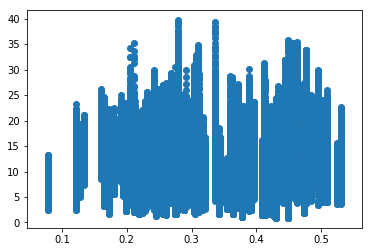

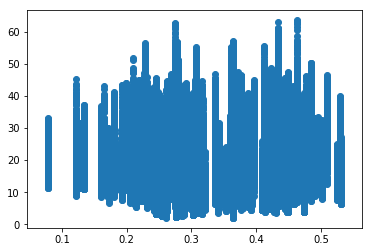

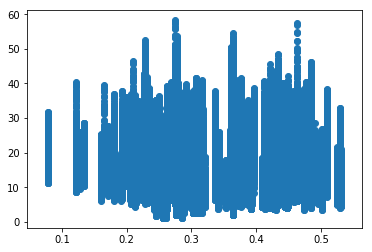

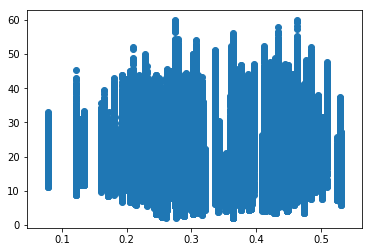

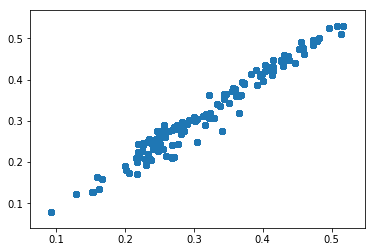

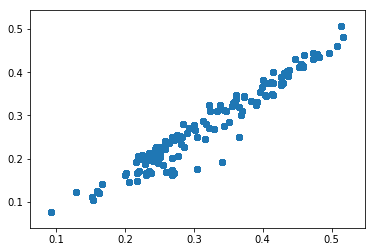

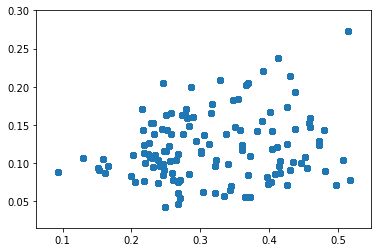

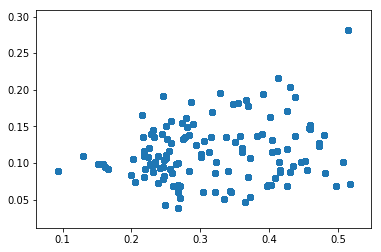

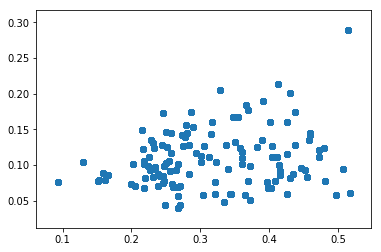

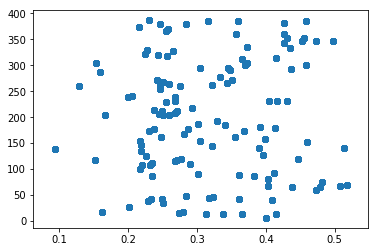

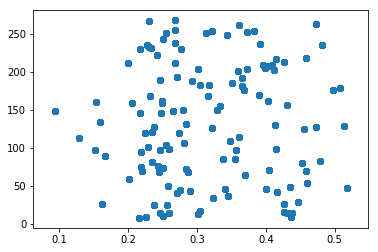

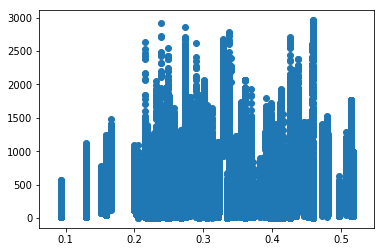

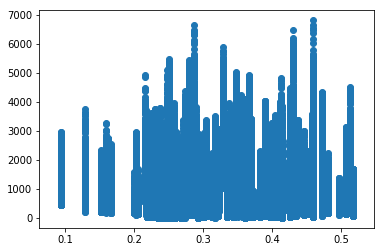

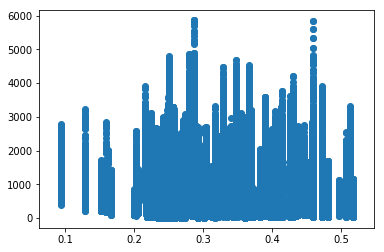

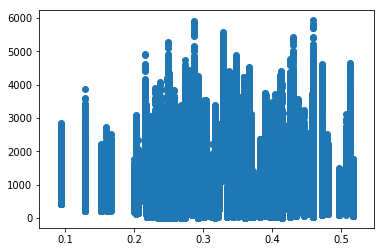

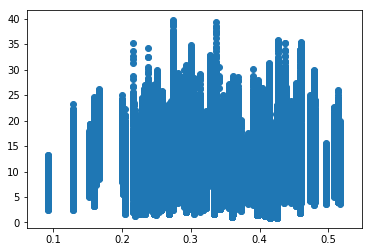

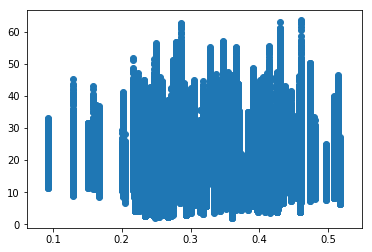

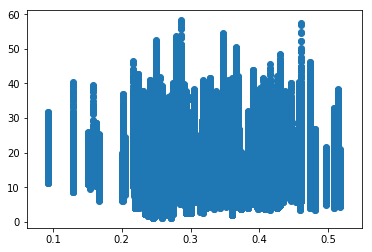

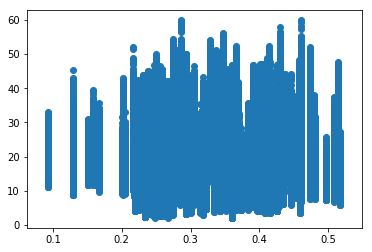

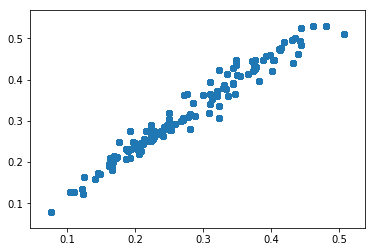

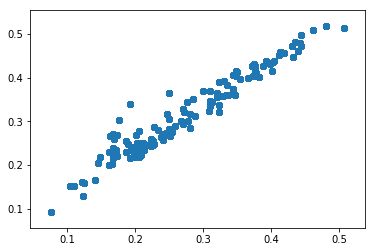

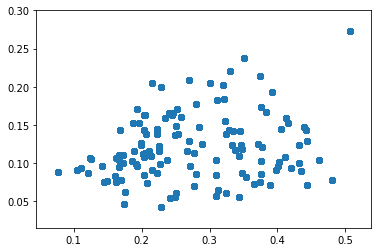

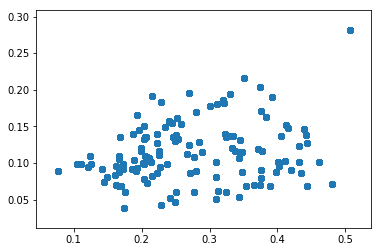

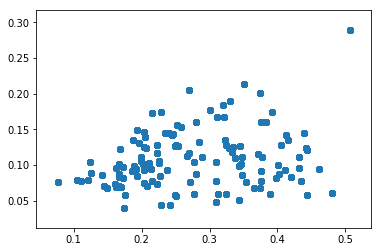

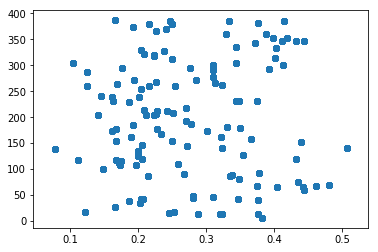

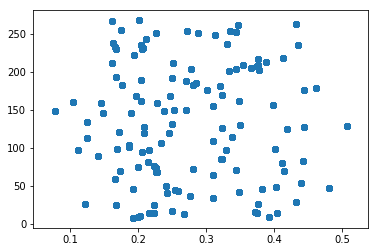

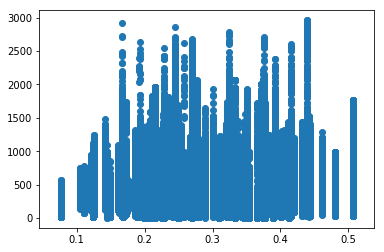

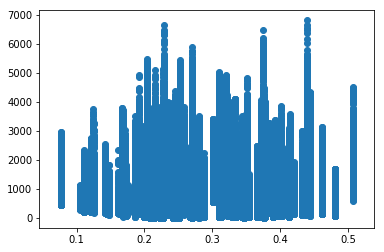

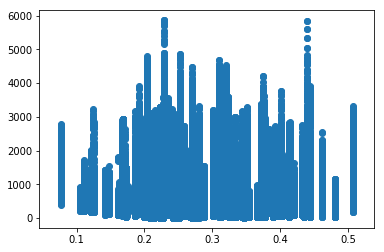

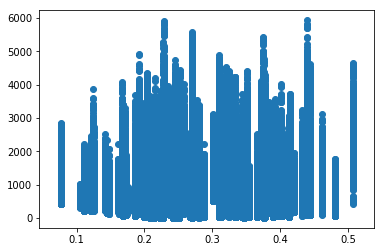

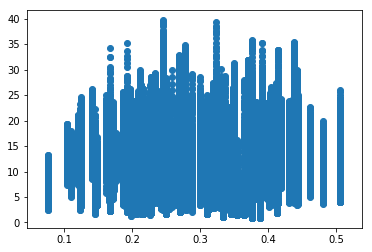

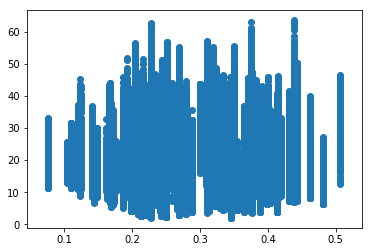

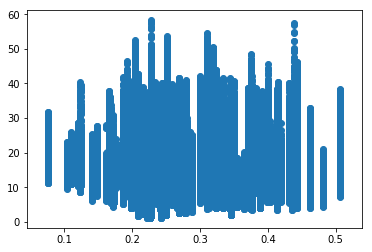

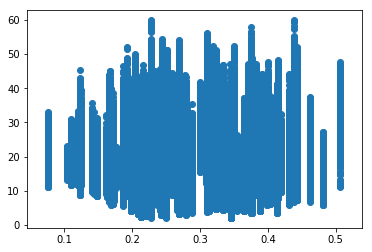

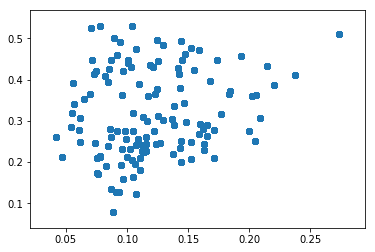

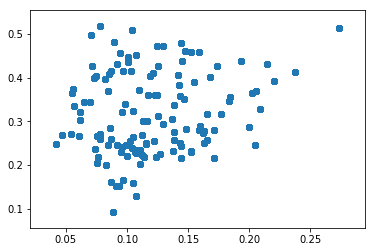

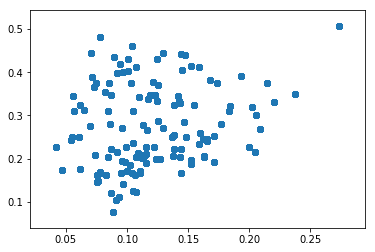

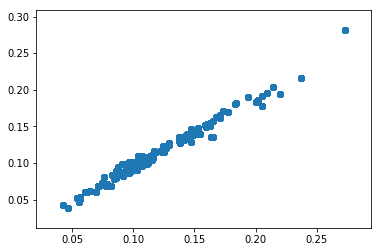

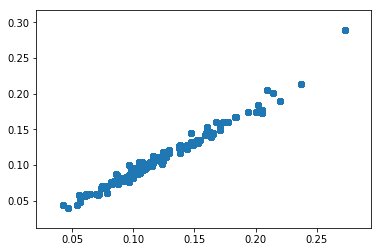

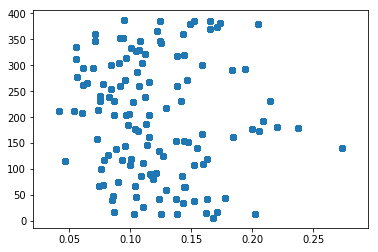

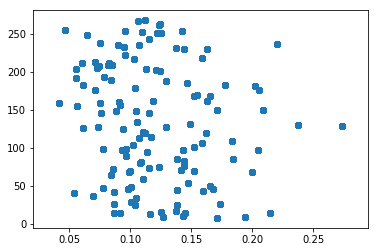

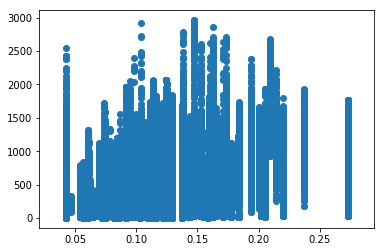

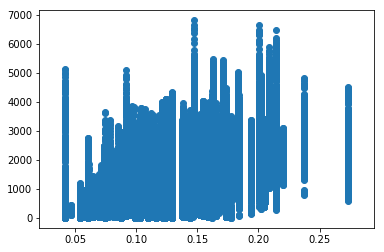

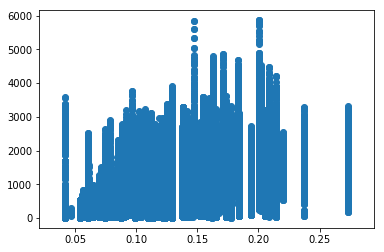

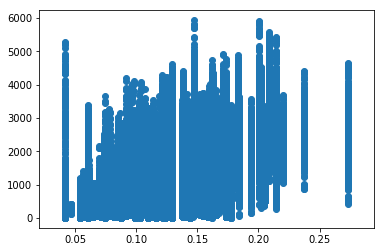

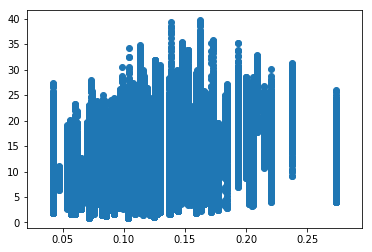

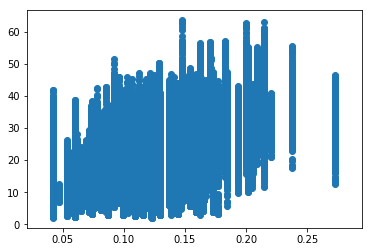

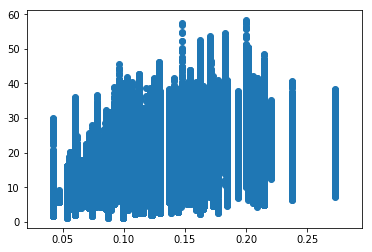

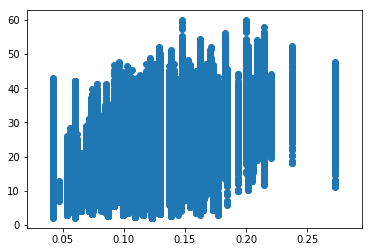

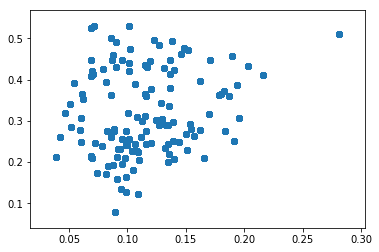

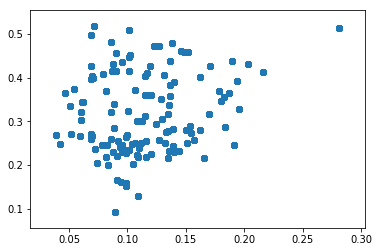

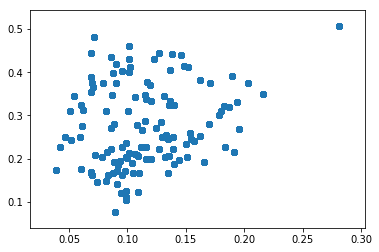

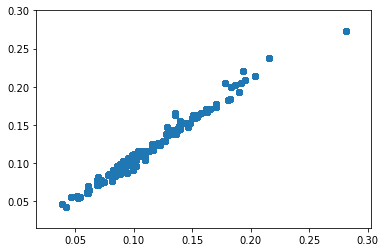

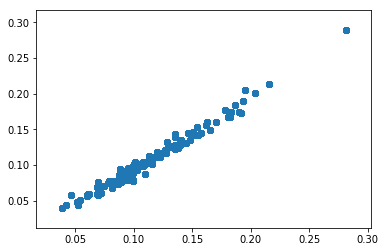

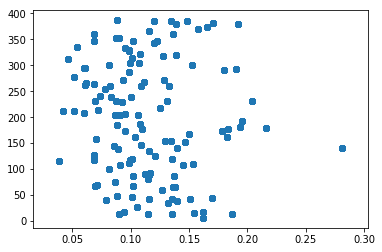

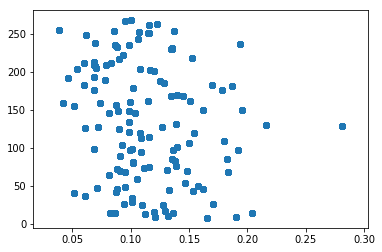

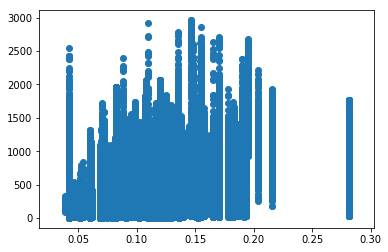

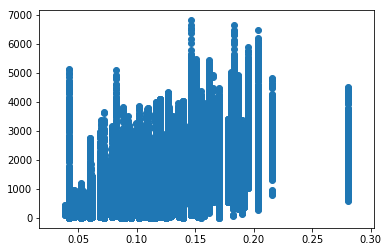

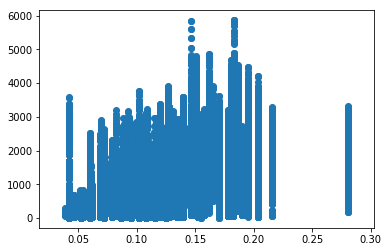

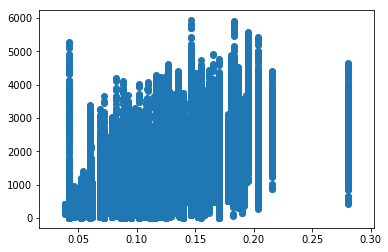

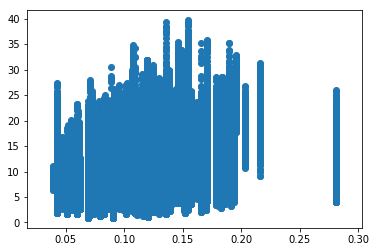

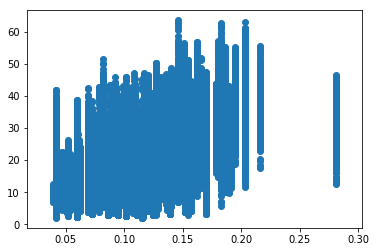

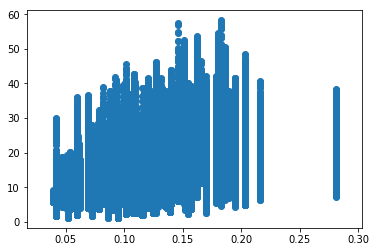

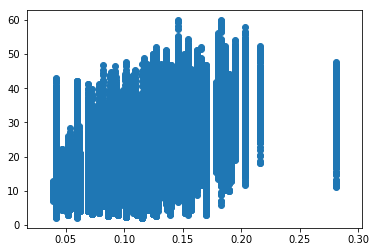

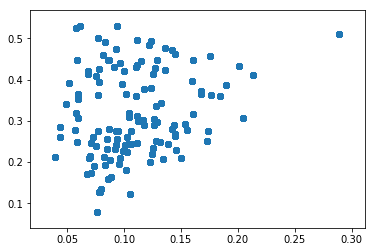

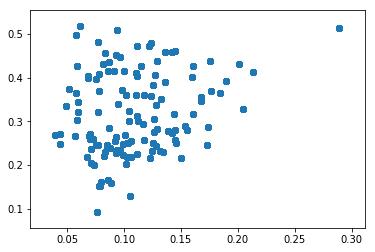

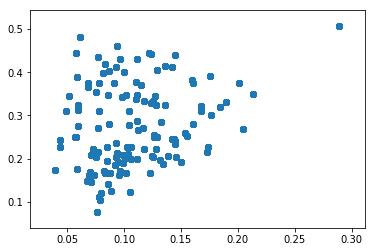

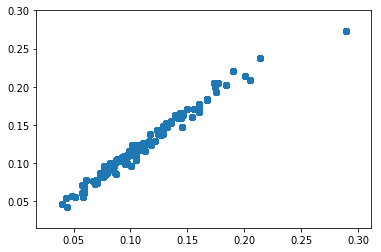

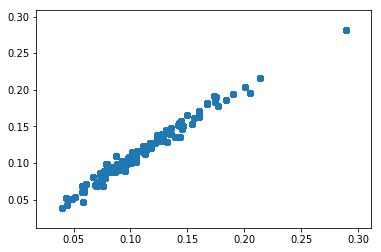

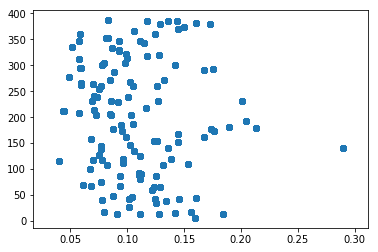

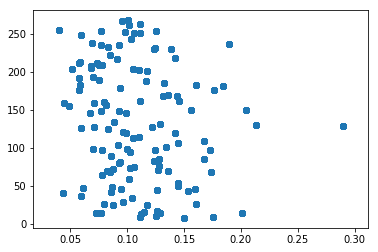

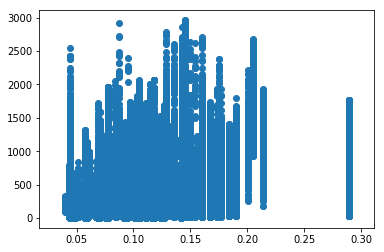

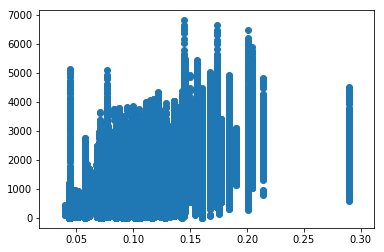

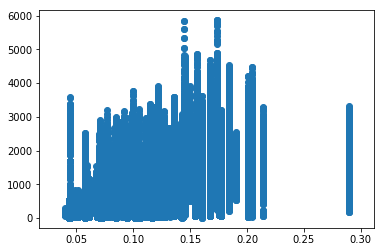

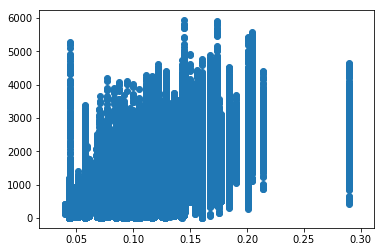

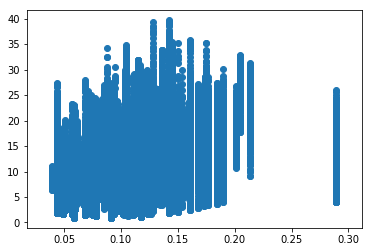

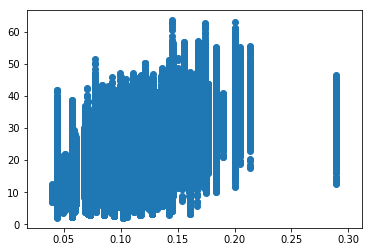

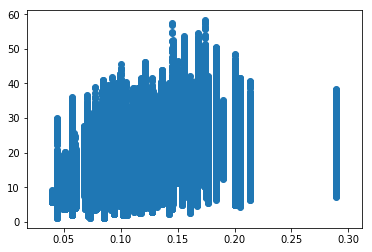

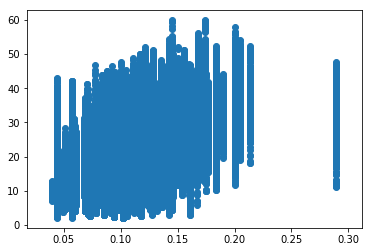

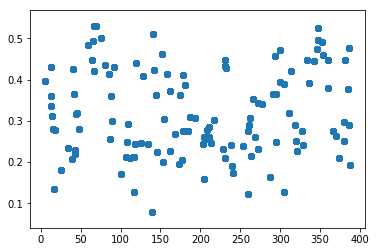

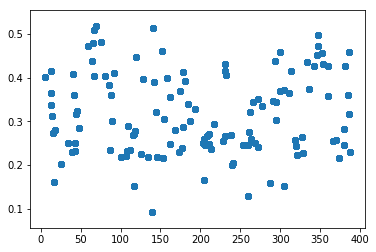

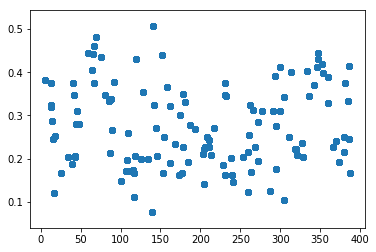

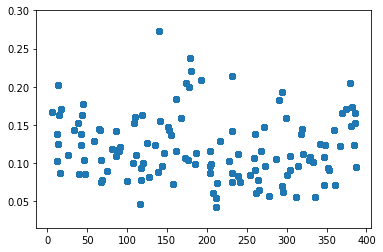

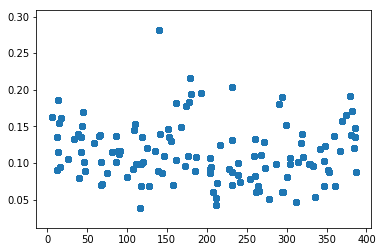

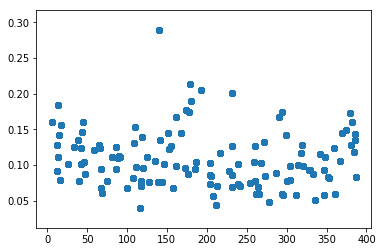

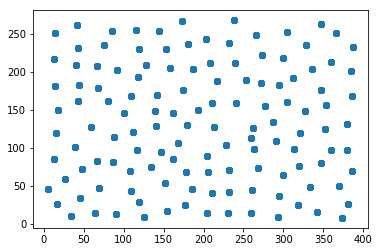

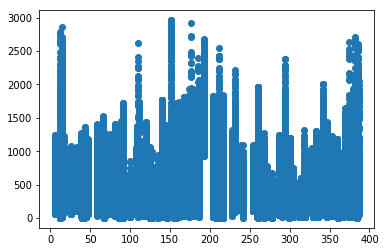

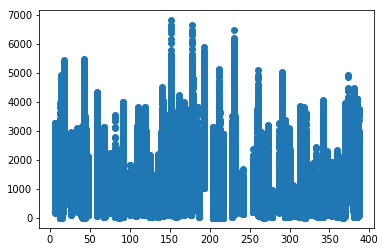

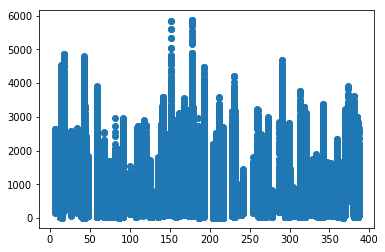

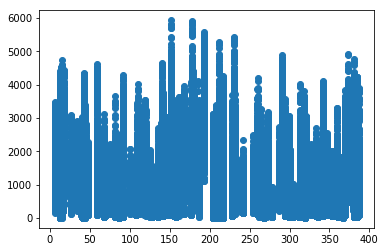

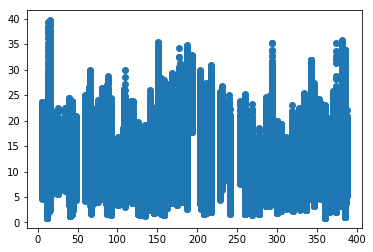

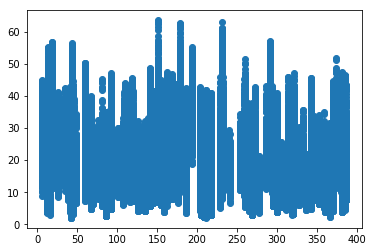

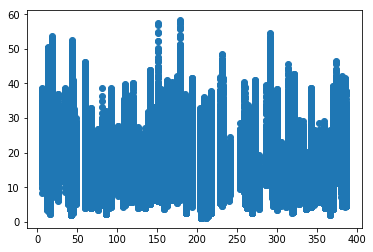

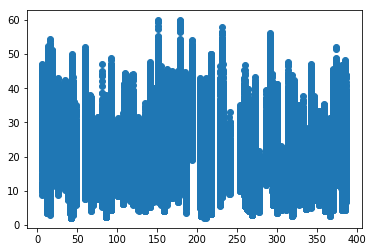

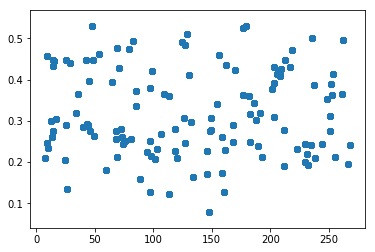

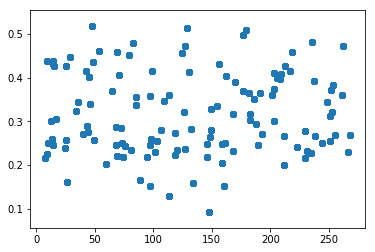

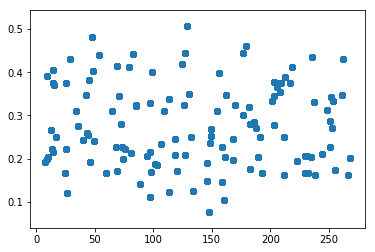

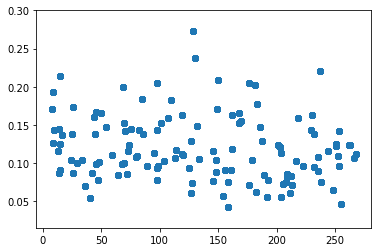

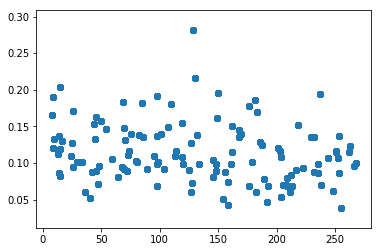

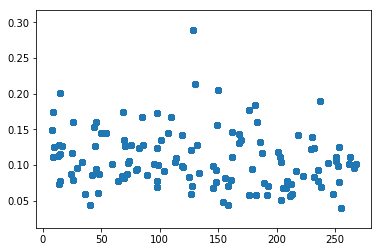

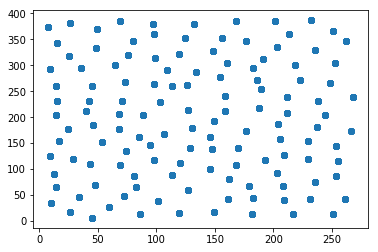

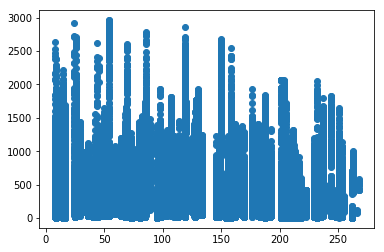

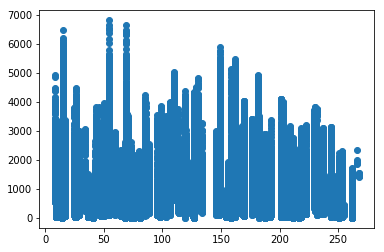

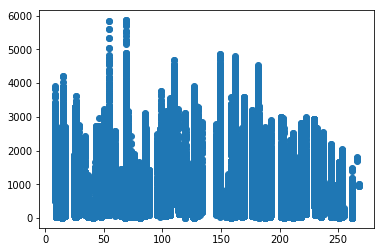

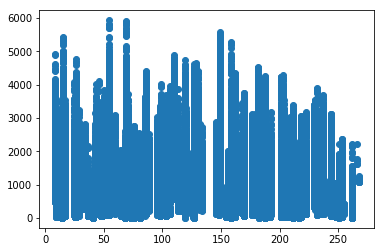

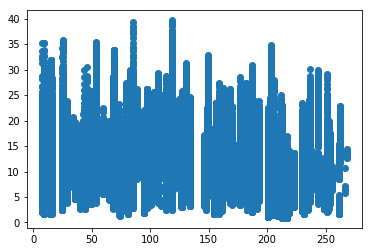

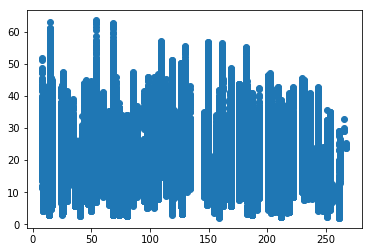

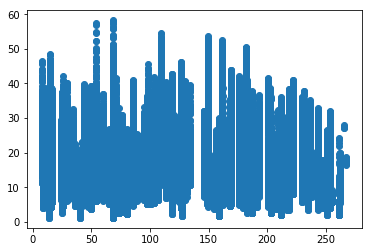

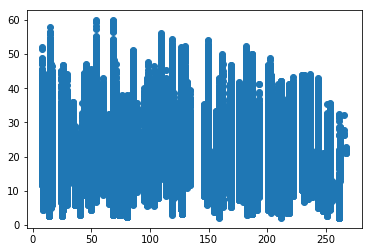

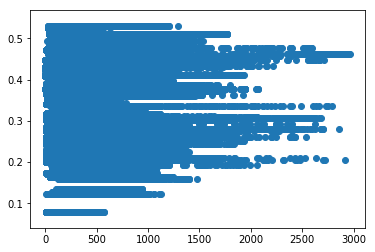

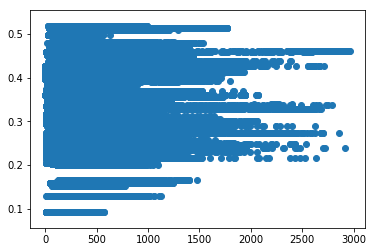

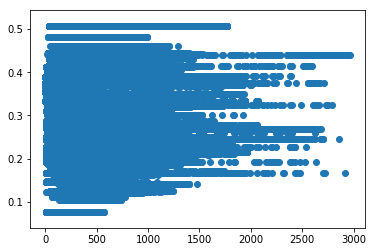

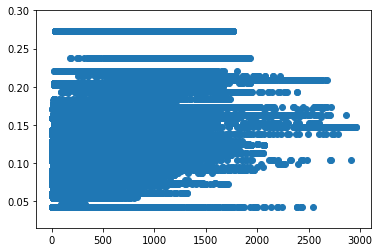

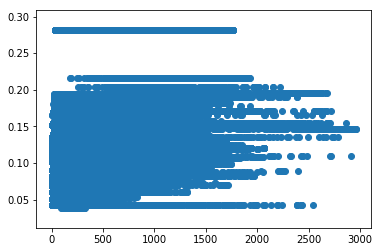

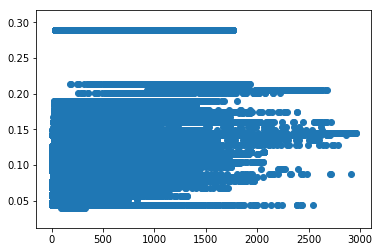

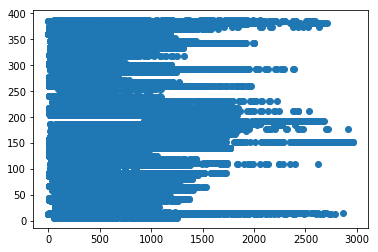

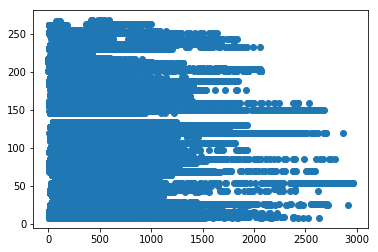

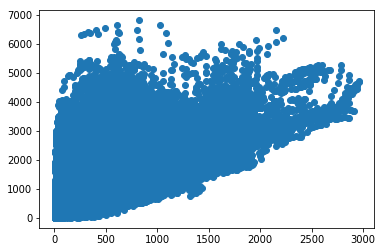

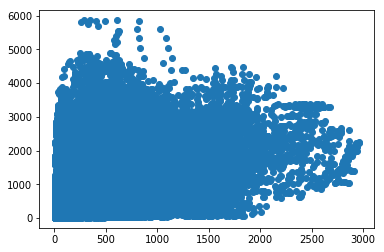

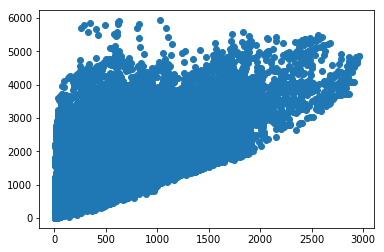

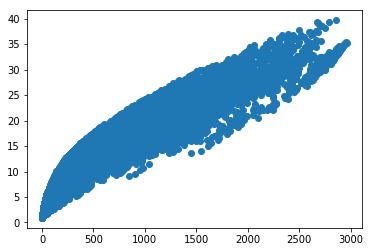

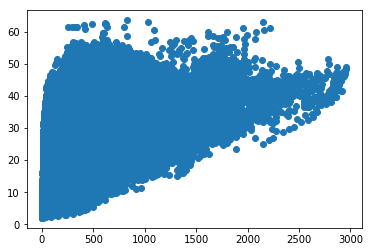

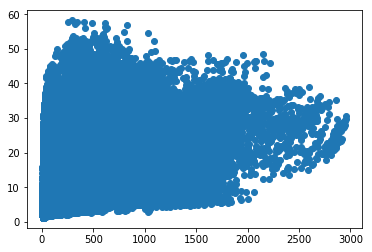

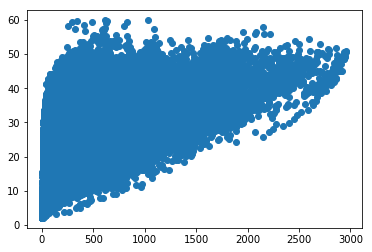

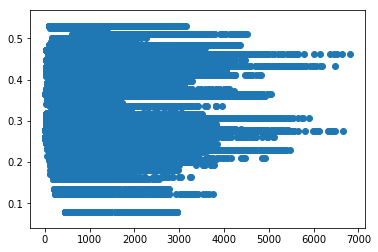

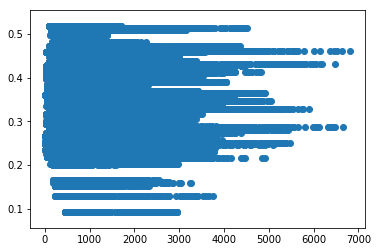

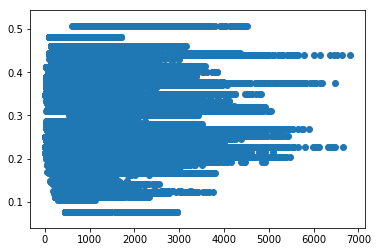

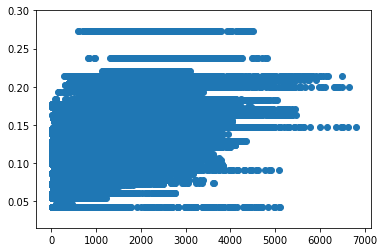

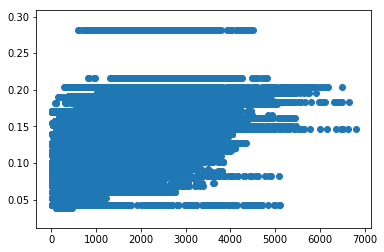

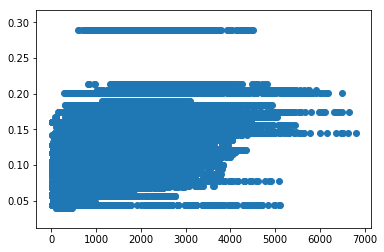

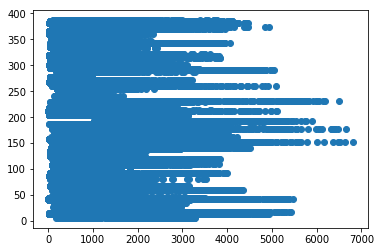

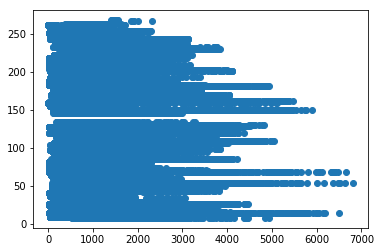

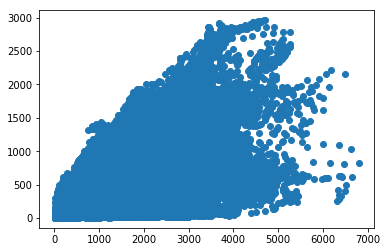

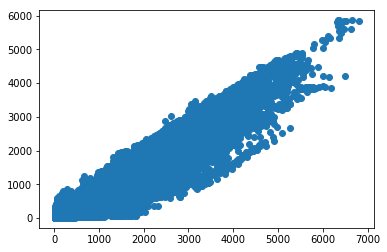

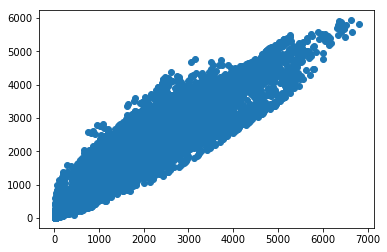

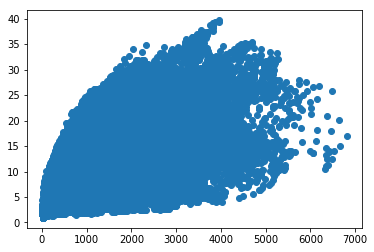

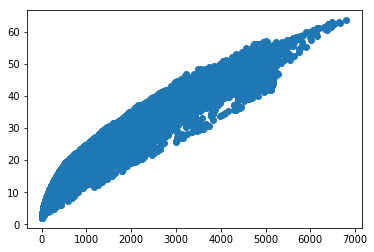

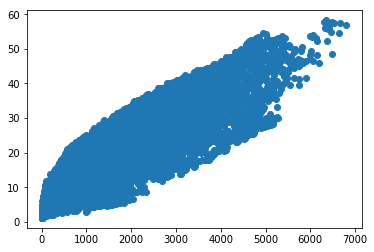

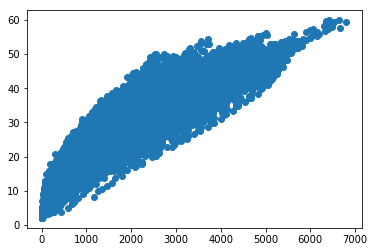

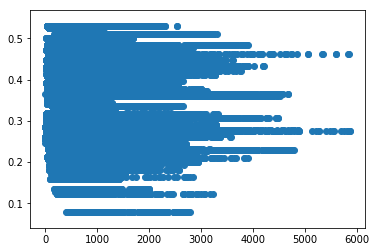

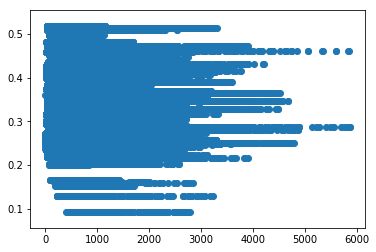

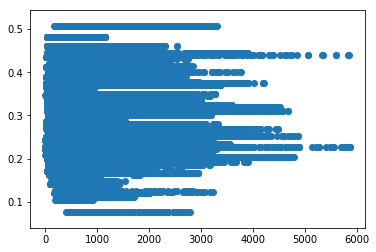

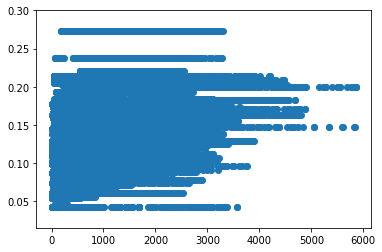

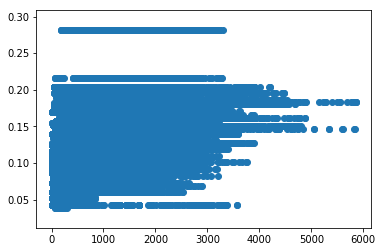

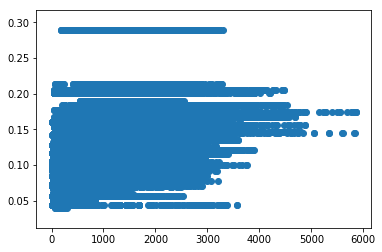

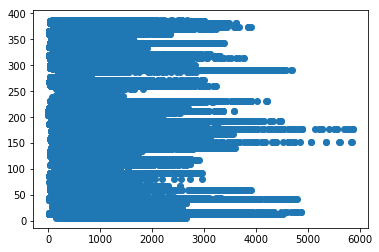

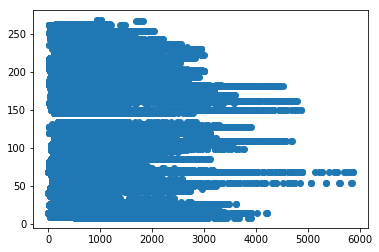

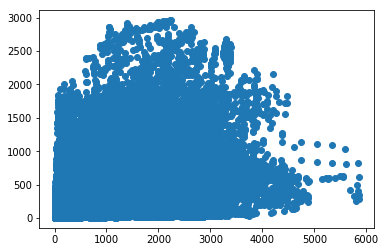

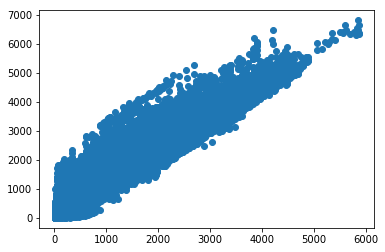

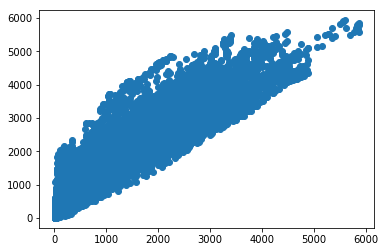

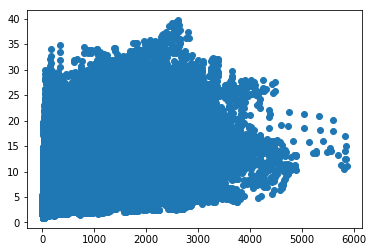

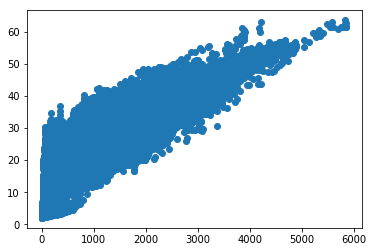

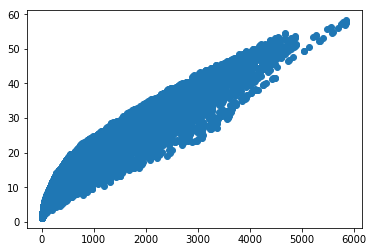

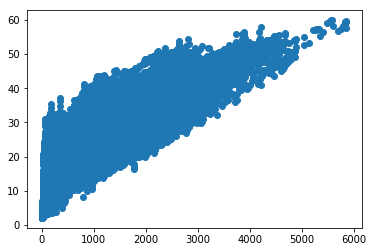

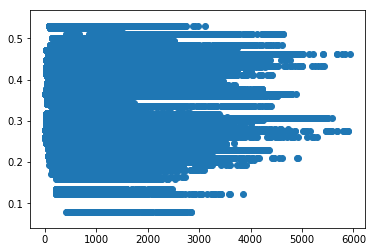

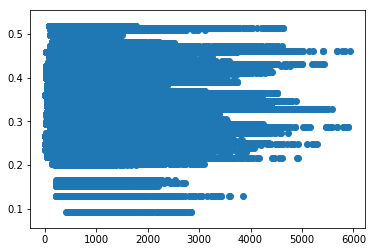

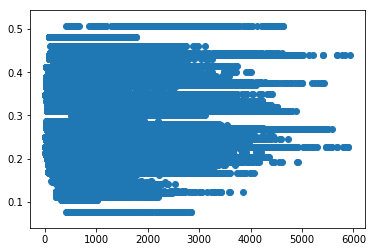

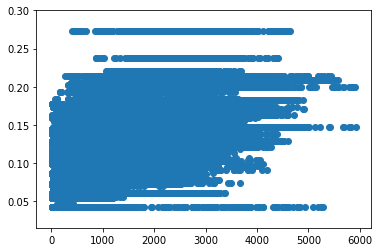

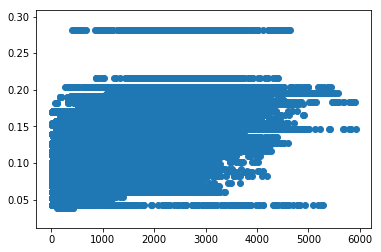

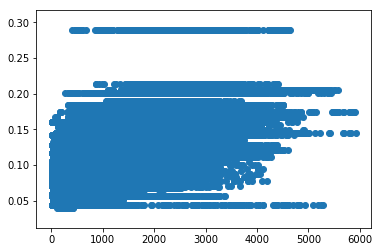

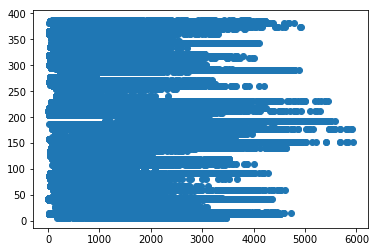

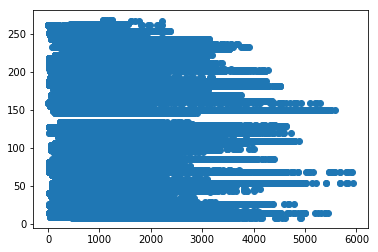

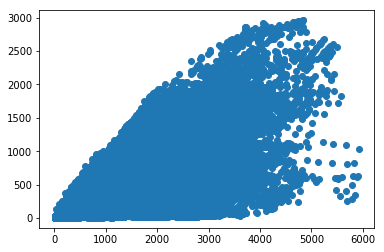

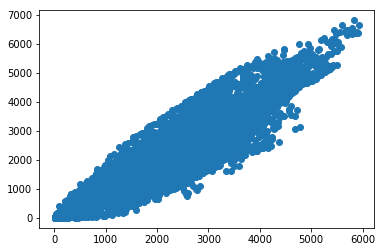

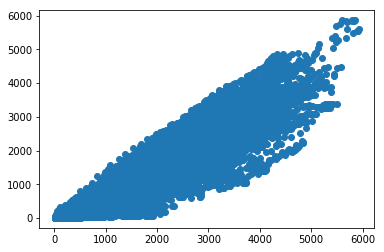

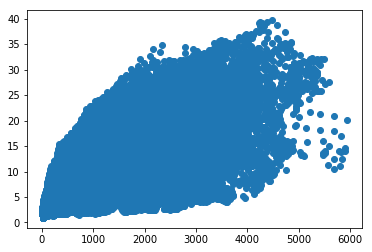

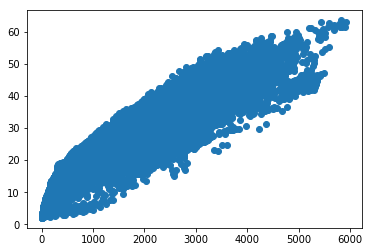

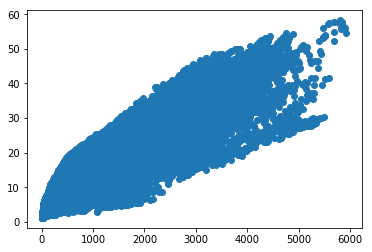

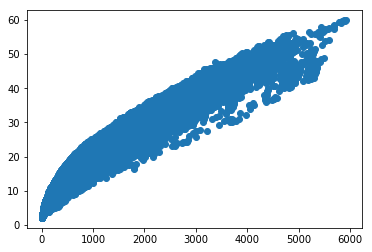

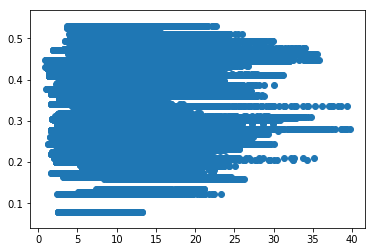

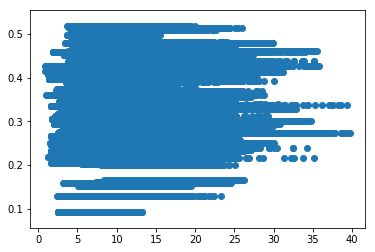

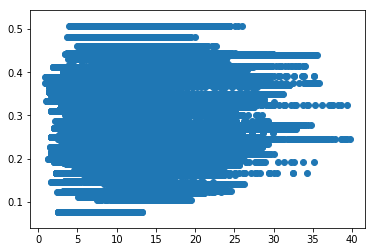

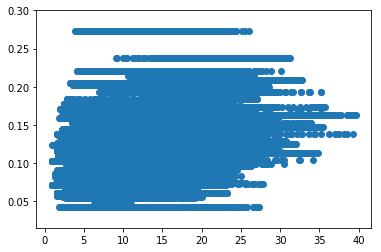

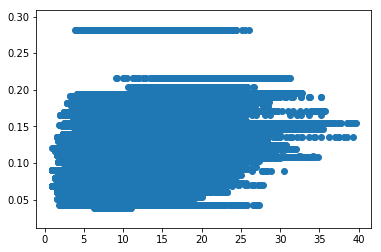

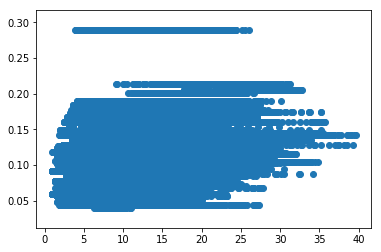

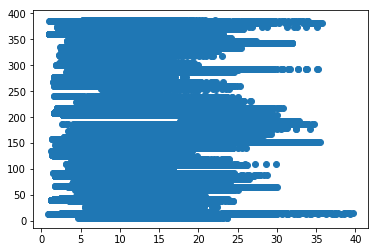

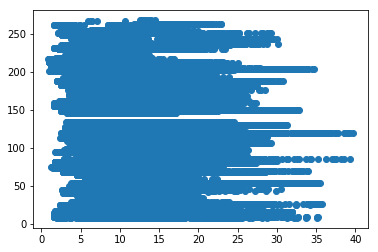

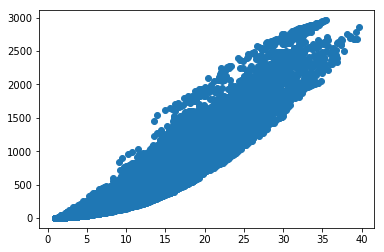

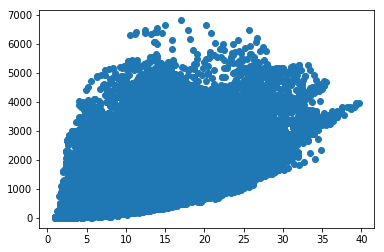

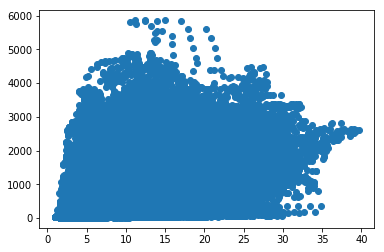

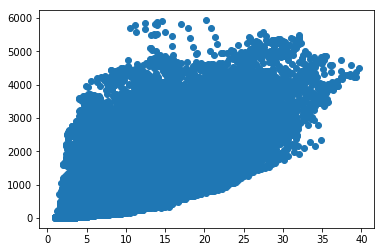

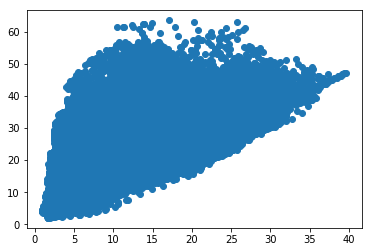

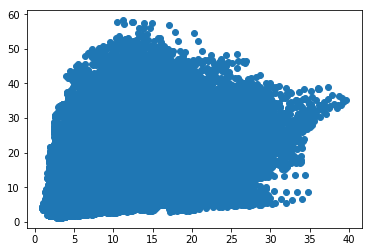

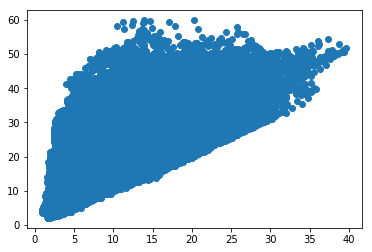

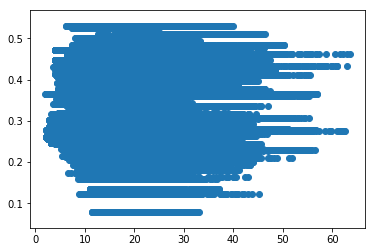

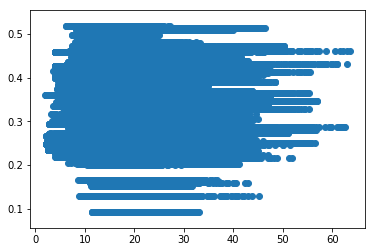

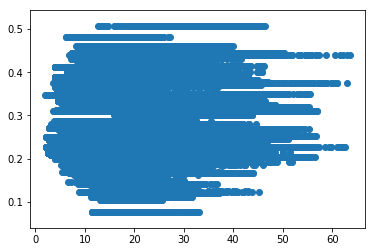

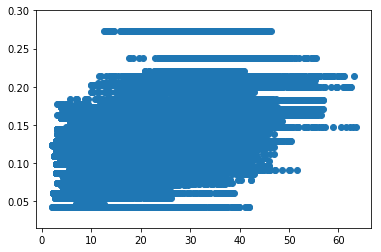

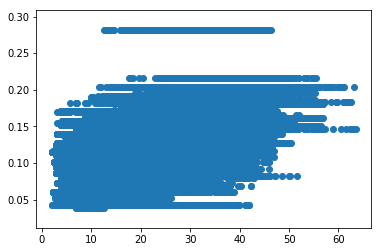

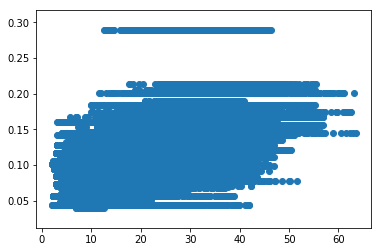

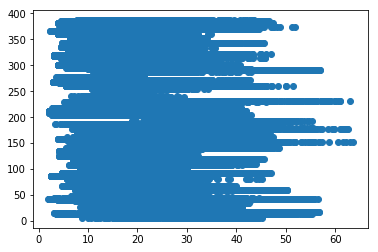

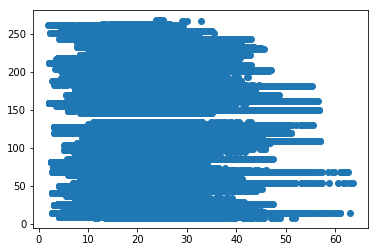

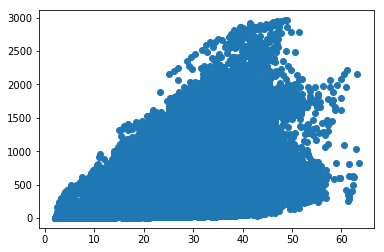

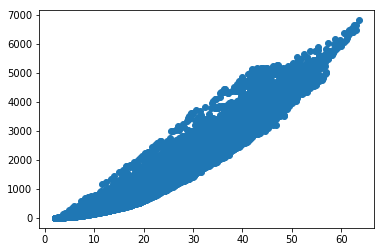

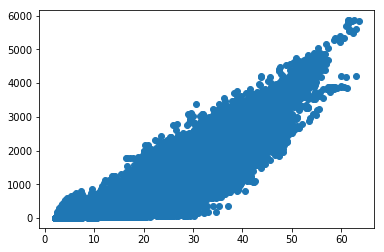

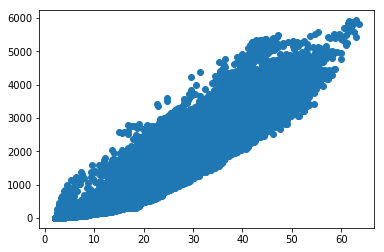

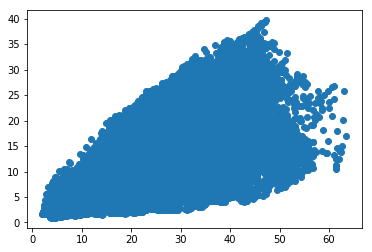

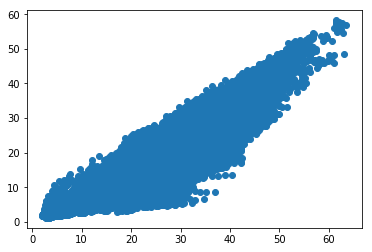

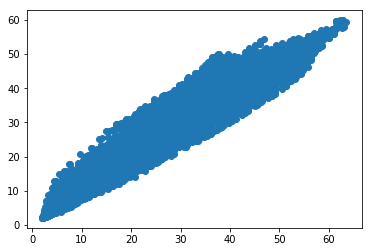

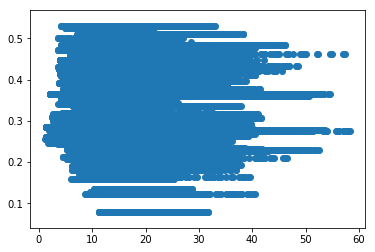

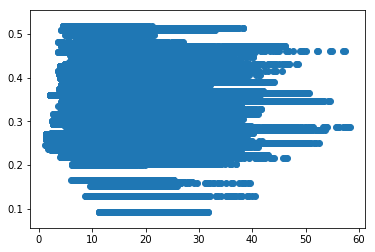

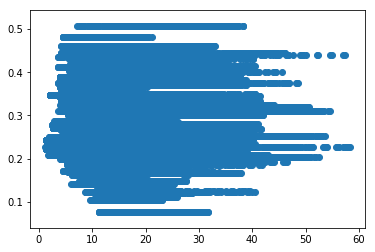

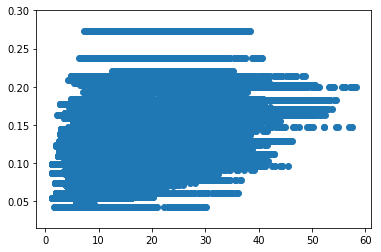

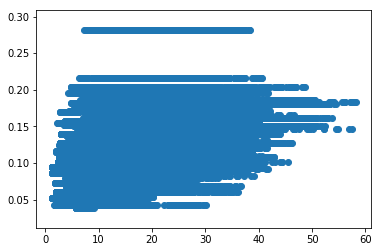

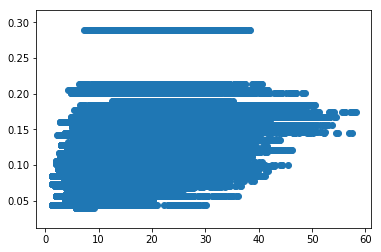

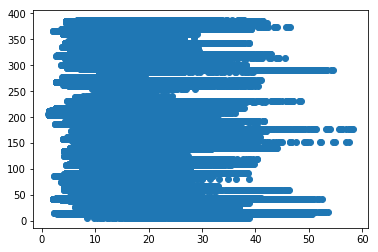

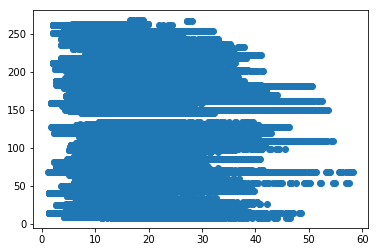

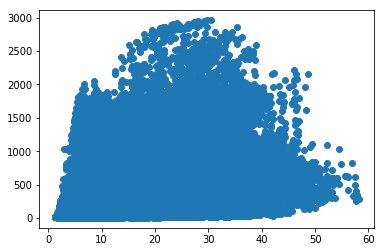

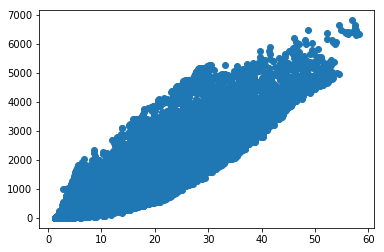

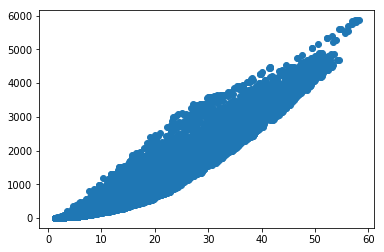

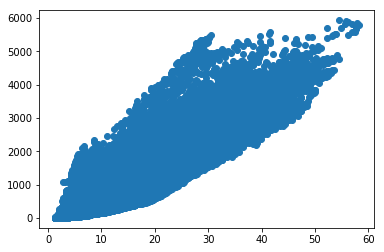

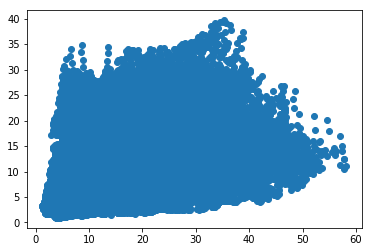

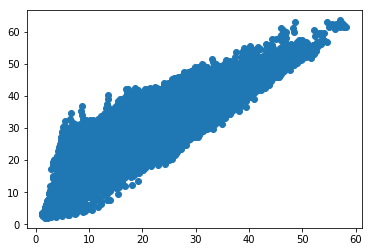

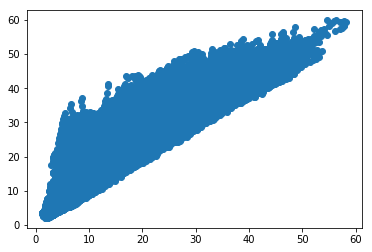

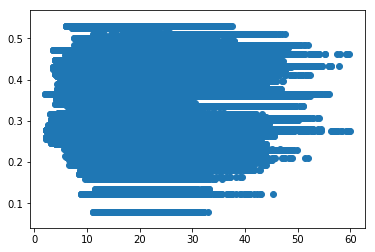

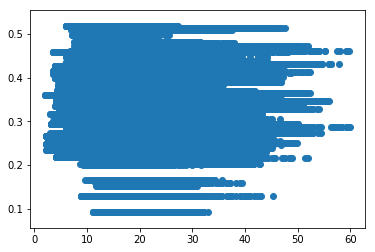

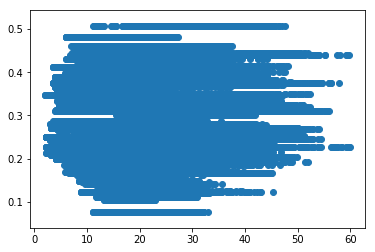

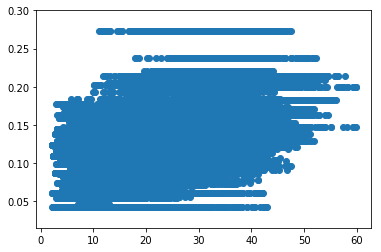

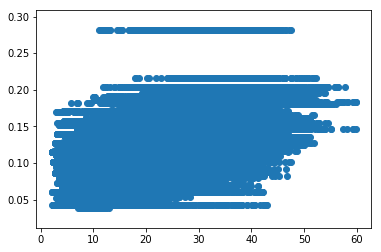

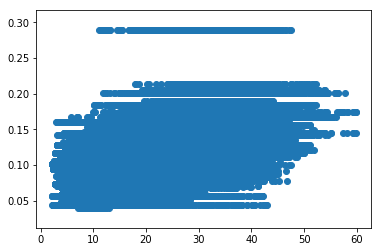

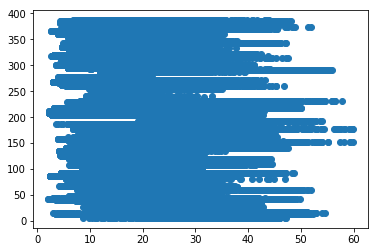

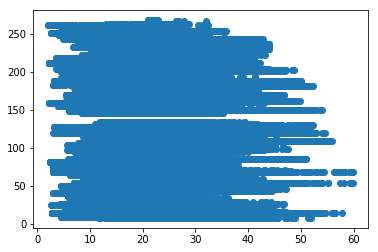

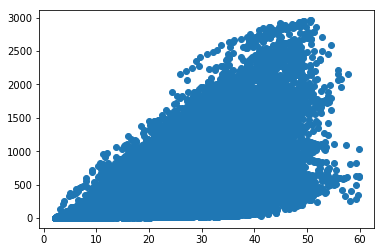

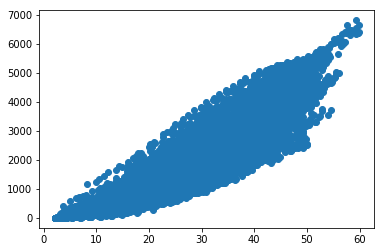

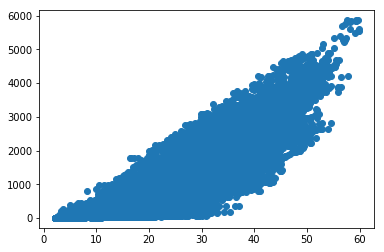

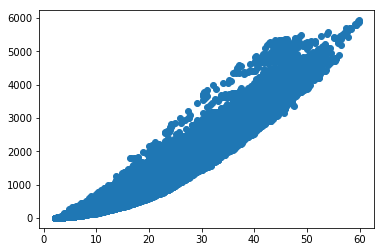

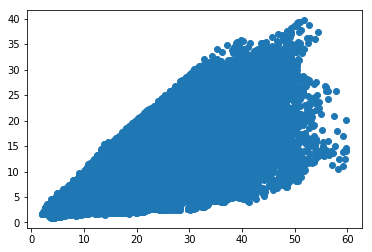

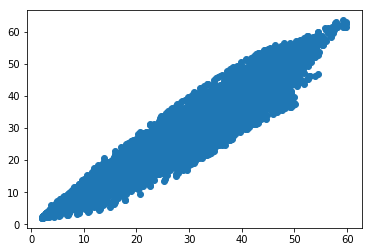

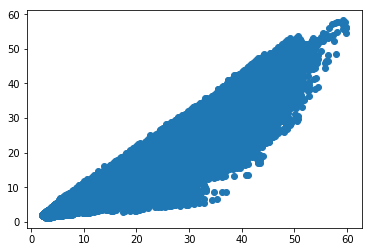

In [10]:
for i,j in tqdm.tqdm(itertools.permutations(range(X.shape[-1]),2)):
    plt.scatter(X[:1000000,i],X[:1000000,j])
    plt.figure()

In [9]:
nb_image=100
nb_features=16
#X=features.reshape((nb_image*img1.shape[0]*img1.shape[1],nb_features))
X=(X-X.mean(axis=0))/X.std(axis=0)
gt_imgs=np.asarray(gt_imgs)
Y=gt_imgs.reshape((100*imgs[0].shape[0]*imgs[0].shape[1]))
#Y0 = [i for i, j in enumerate(Y) if j == 0]
#Y1 = [i for i, j in enumerate(Y) if j == 1]

In [13]:
#hpyer-parameter to vary
pca=decomposition.PCA(n_components=12)
pca.fit(X)
pca.explained_variance_ratio_

array([ 0.51133644,  0.17532289,  0.09534936,  0.06751051,  0.06248237,
        0.06204399,  0.01187683,  0.00568343,  0.00325795,  0.0019604 ,
        0.00139468,  0.00065021])

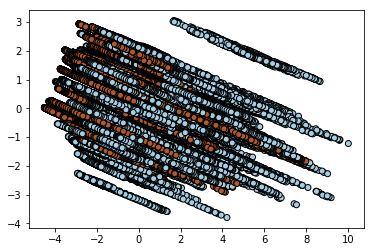

In [10]:
pca = decomposition.PCA(n_components=10)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:100000, 0], X_pca[:100000, 1], c=Y[:100000], cmap=plt.cm.Paired,edgecolors='k');

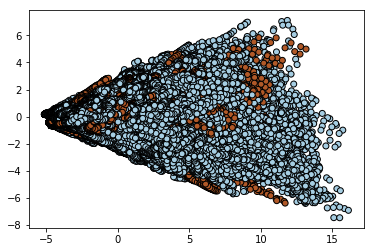

In [15]:
plt.scatter(X_pca[:1000000, 0], X_pca[:1000000, 3], c=Y[:1000000], cmap=plt.cm.Paired,edgecolors='k');

In [11]:
#sklearn.preprocessing.StandardScaler(X_pca)
X_pca=(X_pca-X_pca.mean(axis=0))/X_pca.std(axis=0)

In [52]:
Seed=None
np.random.seed(Seed)
idx = range(X.shape[0])
idx = np.random.permutation(idx)
ratio=100
X_train=X[idx[:X.shape[0]//ratio],:]
Y_train=Y[idx[:X.shape[0]//ratio]]
X_test=X[idx[X.shape[0]//ratio:],:]
Y_test=Y[idx[X.shape[0]//ratio:]]

In [50]:
svc = svm.SVC(kernel='rbf',max_iter=800,decision_function_shape='ovo',C=1e10,gamma=0.01,probability=True,class_weight={1: 10})
svc.fit(X_train,Y_train)
prob=svc.predict_proba(X_train)
Z=svc.predict(X)

c:\python35\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [83]:
score=np.zeros((20,10))
for i,c in enumerate(np.logspace(5,5,num=1)):
    for j,gamma in enumerate(np.logspace(-5,-1,num=10)):
        svc = svm.SVC(kernel='rbf',max_iter=15,decision_function_shape='ovo',C=c,gamma=gamma,probability=True,class_weight={1: 10})
        svc.fit(X_train,Y_train)
        prob=svc.predict_proba(X_train)
        Z=svc.predict(X)
        Zn = np.nonzero(Z)[0]
        Yn = np.nonzero(Y)[0]
        Zp = np.asarray(list(set(range(Z.shape[0]))-set(np.nonzero(Z)[0])))
        Yp = np.asarray(list(set(range(Y.shape[0]))-set(np.nonzero(Y)[0])))

        TP = len(list(set(Yn) & set(Zn)))
        FP = len(list(set(Yp) & set(Zn)))
        FN = len(list(set(Yn) & set(Zp)))
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        score[i,j] = 2*Precision*Recall/(Precision+Recall)
np.argmax(score)
        

c:\python35\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


7

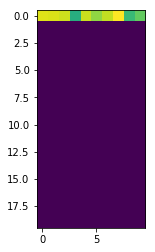

In [84]:
plt.imshow(score,interpolation='Nearest')

Calculate result for C [-1:10] and gamma [0.1 1]

In [21]:
# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e-1, class_weight="balanced")
logreg.fit(X_pca, Y)

# Predict on the training set
Z = logreg.predict(X_pca)

KeyboardInterrupt: 

In [51]:
# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]
Zp = np.asarray(list(set(range(Z.shape[0]))-set(np.nonzero(Z)[0])))
Yp = np.asarray(list(set(range(Y.shape[0]))-set(np.nonzero(Y)[0])))

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
TP = len(list(set(Yn) & set(Zn)))
FP = len(list(set(Yp) & set(Zn)))
FN = len(list(set(Yn) & set(Zp)))
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
score = 2*Precision*Recall/(Precision+Recall)
print('True positive rate = ' + str(TPR))
print('Score is: {}'.format(score))

True positive rate = 0.096481625
Score is: 0.3207573476044899


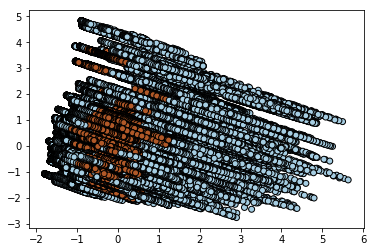

In [43]:
plt.scatter(X_pca[:1000000, 0], X_pca[:1000000, 1], c=Z[:1000000], cmap=plt.cm.Paired,edgecolors='k');

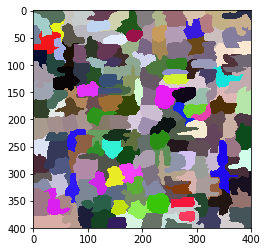

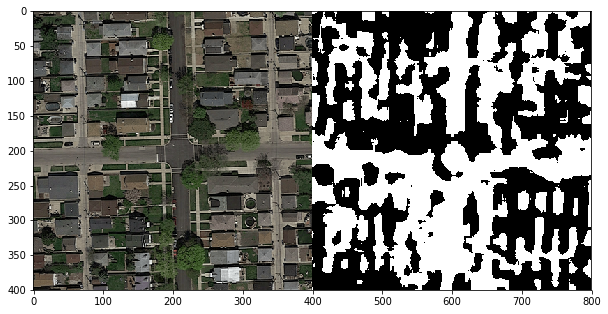

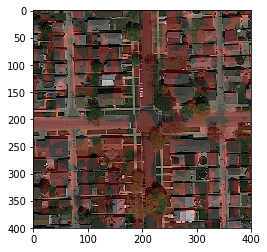

In [20]:
im=0
im_X=X[im*160000:(im+1)*160000]
false_im=im_X[:,:3].reshape(imgs[0].shape)
plt.imshow(false_im)
im_X_pca=pca.transform(im_X)
Z=logreg.predict(im_X_pca)

plt.figure()
w=imgs[im].shape[0]
h=imgs[im].shape[1]
predicted_im = label_to_img(w, h, 1, 1, Z)
cimg = concatenate_images(imgs[im], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')
plt.figure()

new_img = make_img_overlay(imgs[im], predicted_im)

plt.imshow(new_img)

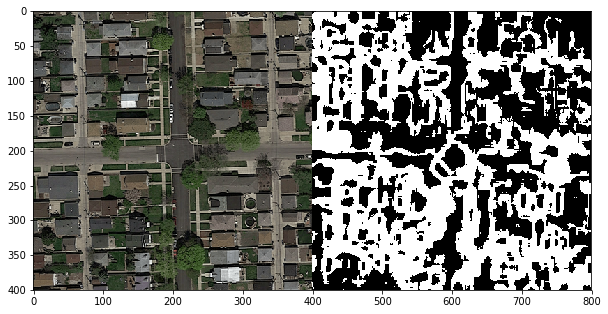

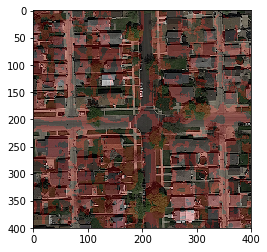

In [44]:
im=0
w=imgs[im].shape[0]
h=imgs[im].shape[1]
predicted_im = label_to_img(w, h, 1, 1, Z[im*160000:(im+1)*160000])
cimg = concatenate_images(imgs[im], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')
plt.figure()

new_img = make_img_overlay(imgs[im], predicted_im)

plt.imshow(new_img)

In [ ]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img2],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
edges = cv2.Canny(img2,200,200)
plt.imshow(edges,cmap='gray')

In [ ]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [ ]:
label_patches=np.asarray([value_to_class(gt_patches[i]) for i in range(len(gt_patches))])

In [ ]:
def compute_loss(imgs,labels,model,fun=None,*args):
    pred=fun(imgs,model,args)
    correct=np.sum(pred==labels)
    return 100 -100*correct/len(imgs)

def compute_loss_pred(labels, pred):
    correct = np.sum(pred==labels)
    return 100-100*correct/len(labels)

In [ ]:
def build_rand_indices(nb_patches,k_fold, seed=None):
    interval = int(nb_patches / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(nb_patches)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validate(imgs,labels, indices, k, fun=None, *args):
    test_ind=indices[k]
    train_ind=indices[[i for i in range(indices.shape[0]) if i!=k]]
    train_ind=train_ind.reshape(-1)
    
    img_test=imgs[test_ind]
    label_test=labels[test_ind]
    img_train=imgs[train_ind]
    label_test=labels[train_ind]
    
    model,loss_tr=fun(args) # magnifique fonction qui gere
    loss_te=compute_loss(img_test,label_test,model) # compute loss of test (getPredictions and percentage of correct predictions)
    return model

In [ ]:
k_ind=build_rand_indices(len(img_patches),4)
results=cross_validate(img_patches,gt_patches,k_ind,2)

In [ ]:
def mask_to_submission(filename,masks, ids):
    """Converts images into a submission file"""
    with open(filename, 'w') as f:
        f.write('id,prediction\n')
        for fn,id_ in masks, ids:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, id_))
            
def mask_to_submission_strings(image, number):
    """Outputs the strings that should go into the submission file from the prediction mask"""
    step=1
    for j in range(0, image.shape[1], step):
        for i in range(0, image.shape[0], step):
            label = image[i, j]
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))

In [11]:
import os
test_dir = "dataset/test_set_images/"
dirs = os.listdir(test_dir)
n_test=min(50, len(dirs))

imgs_test = [load_image(test_dir+dirs[i]+"/"+dirs[i]+".png") for i in range(n_test)]

In [30]:
[72200//(38*38*50)]

[1]